In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
from torch.autograd import Variable
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import multiprocess as mp
import torchvision
import piq

training_data_images = np.load('Training_data_on_LCD.npz')['train']
training_data_labels = np.load('Binary_Pixel_MNIST_Data_for_LCD_Microlens_120_120.npz')['labels']
testing_data_images = np.load('Testing_data_on_LCD.npz')['test']
testing_data_labels = np.load('Binary_Pixel_MNIST_Data_for_LCD_Microlens_120_120_test.npz')['labels']
data_images = np.concatenate((training_data_images, testing_data_images))
data_labels = np.concatenate((training_data_labels, testing_data_labels))

print(training_data_images.shape[0])
print(testing_data_images.shape[0])

2000
300


In [2]:
torch.manual_seed(100)
transforms_noise = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(5, translate=(0.02, 0.02), \
                                                                                       scale=(0.98, 1.02)),\
                                                   torchvision.transforms.GaussianBlur(7),\
                                                   torchvision.transforms.Resize((14, 14)),\
                                                   torchvision.transforms.ToTensor()])
#Fashion MNIST
train = torchvision.datasets.MNIST('../../Smart Sensor - Image Compression/MNIST', train=True, download=True, transform=transforms_noise)

test = torchvision.datasets.MNIST('../../Smart Sensor - Image Compression/MNIST', train=False, download=True, transform=transforms_noise)

cutoff = 0.2
class MNIST_Fashion_Dataset(Dataset):
    def __init__(self, mode) :
        self.mode = mode
        self.data = []
        self.labels = []
        if (mode == 'train'):
            for i, data in enumerate(train):
                self.data.append(data[0].reshape(14*14)/data[0].max())
                self.labels.append(data[1])
                #self.labels.append(data[0].reshape(784))
                #self.labels.append(torch.relu(torch.sign(data[0] - cutoff)))
        if (mode == 'test'):
            for i, data in enumerate(test):
                self.data.append(data[0].reshape(14*14)/data[0].max())
                self.labels.append(data[1])
                #self.labels.append(data[0].reshape(784))
                #self.labels.append(torch.relu(torch.sign(data[0] - cutoff)))
                
    def __len__(self) :
        return len(self.labels)
        
    def __getitem__(self, idx) :
        return self.data[idx], self.labels[idx]
    
class Fanout_MNIST_Dataset(Dataset):
    def __init__(self, mode) :
        self.mode = mode
        self.data = []
        self.labels = []
        self.inds = [3, 121, 240]
        self.window_mat = np.zeros((8, 8))
        self.window_mat[1:6, 1:6] = 1
        self.window_mat = np.tile(self.window_mat, (14, 14))
        if (mode == 'train'):
            for p in range (training_data_images.shape[0]):
                ROI = training_data_images[p][120:472, 224:576]
                for i in range (3):
                    for j in range (3):
                        fanout_copy = ROI[self.inds[i] : self.inds[i] + 112, self.inds[j] : self.inds[j] + 112]
                        vec_image = self.window_mat*fanout_copy
                        n1 = 8
                        n2 = 8
                        b = vec_image.shape[0]//n1
                        vec = vec_image.reshape(-1, n1, b, n2).sum((-1, -3))/(5*5)
                        self.data.append(torch.tensor(np.copy(vec.reshape(14*14)/vec.max()), dtype = torch.float32))
                        self.labels.append(np.copy(training_data_labels[p]))
        if (mode == 'test'):
            for p in range (testing_data_images.shape[0]):
                ROI = testing_data_images[p][120:472, 224:576]
                for i in range (3):
                    for j in range (3):
                        fanout_copy = ROI[self.inds[i] : self.inds[i] + 112, self.inds[j] : self.inds[j] + 112]
                        vec_image = self.window_mat*fanout_copy
                        n1 = 8
                        n2 = 8
                        b = vec_image.shape[0]//n1
                        vec = vec_image.reshape(-1, n1, b, n2).sum((-1, -3))/(5*5)
                        self.data.append(torch.tensor(np.copy(vec.reshape(14*14)/vec.max()), dtype = torch.float32))
                        self.labels.append(np.copy(testing_data_labels[p]))
    def __len__(self) :
        return len(self.labels)

    def __getitem__(self, idx) :
        return self.data[idx], self.labels[idx]

    
train_data = MNIST_Fashion_Dataset('train')
test_data = MNIST_Fashion_Dataset('test')
fanout_train_data = Fanout_MNIST_Dataset('train')
fanout_test_data = Fanout_MNIST_Dataset('test')

torch.Size([196])


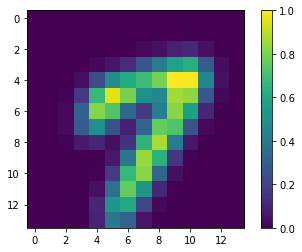

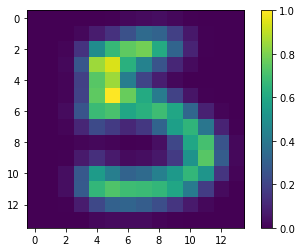

torch.Size([196])


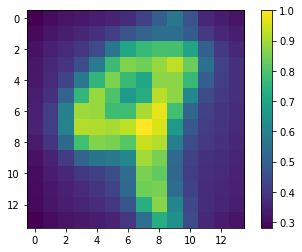

9


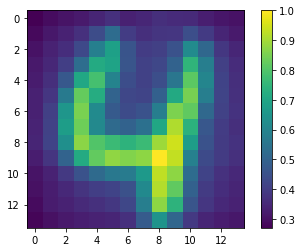

4
2700
18000


In [3]:
for i,data in enumerate(train_data):
    if(i==15):
        print(data[0].shape)
        plt.figure()
        plt.imshow(data[0].reshape(14, 14))
        plt.colorbar()
        plt.show()
N_train_samp = i + 1
for i,data in enumerate(test_data):
    if(i==15):
        plt.figure()
        plt.imshow(data[0].reshape(14, 14))
        plt.colorbar()
        plt.show()
N_test_samp = i + 1

for i,data in enumerate(fanout_train_data):
    if(i==36):
        print(data[0].shape)
        plt.figure()
        plt.imshow(data[0].reshape(14, 14))
        plt.colorbar()
        plt.show()
        print(data[1])
N_fanout_train_samp = i + 1

for i,data in enumerate(fanout_test_data):
    if(i==36):
        plt.figure()
        plt.imshow(data[0].reshape(14, 14))
        plt.colorbar()
        plt.show()
        print(data[1])
N_fanout_test_samp = i + 1

print(N_fanout_test_samp)
print(N_fanout_train_samp)

In [4]:
batch_size = 100
train_dataset = DataLoader(train_data, batch_size = batch_size, shuffle = False)
test_dataset = DataLoader(test_data, batch_size = batch_size, shuffle = False)
N_train_batch = int(N_train_samp/batch_size)
N_test_batch = int(N_test_samp/batch_size)
print(N_train_batch)
print(N_test_batch)
fanout_train_dataset = DataLoader(fanout_train_data, batch_size = batch_size, shuffle = False)
fanout_test_dataset = DataLoader(fanout_test_data, batch_size = batch_size, shuffle = False)
N_fanout_train_batch = int(N_fanout_train_samp/batch_size)
N_fanout_test_batch = int(N_fanout_test_samp/batch_size)
print(N_fanout_train_batch)
print(N_fanout_test_batch)

600
100
180
27


In [11]:
#Device
dev = 'cuda:3'
device = torch.device(dev if torch.cuda.is_available() else "cpu")
if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()
        
class AutoEncoder(nn.Module):
    def __init__(self, n_inps, n_compressed, batch):
        super(AutoEncoder, self).__init__()
        self.n_inputs = n_inps
        self.n_compressed = n_compressed
        self.W_Opt1 = nn.Parameter(torch.randn(self.n_inputs, self.n_compressed, requires_grad = True)*0.1)
        #self.W_Opt2 = nn.Parameter(torch.randn(512, self.n_compressed, requires_grad = True)*0.1)
        self.FCmu = nn.Linear(self.n_compressed, self.n_compressed, bias = True)
        self.FCvar = nn.Linear(self.n_compressed, self.n_compressed, bias = True)
        self.FC2 = nn.Linear(self.n_compressed, 512, bias = True)
        self.FC3 = nn.Linear(512, self.n_inputs, bias = True)
        #self.FC4 = nn.Linear(600, , bias = True)
        self.noise = 0.05
        
    def reparametrize(self,mu,log_var):
        #Reparametrization Trick to allow gradients to backpropagate from the 
        #stochastic part of the model
        sigma = torch.exp(0.5*log_var)
        z = torch.randn(size = (mu.size(0),mu.size(1)))
        z = z.type_as(mu) # Setting z to be .cuda when using GPU training 
        return mu + sigma*z
        
    def forward(self, X):
        W_Opt1 = torch.clamp(self.W_Opt1 +\
        self.noise*torch.rand(self.W_Opt1.shape, requires_grad = True, device = device), min=0., max=1.)
        #W_Opt2 = torch.clamp(self.W_Opt2, min=0., max=1.)
        Y = torch.matmul(X, W_Opt1)
        #Y = 1. - torch.exp(-1.*Y/0.7)
        #Y = torch.matmul(Y, W_Opt2)
        Y = Y/Y.max()
        mu = self.FCmu(Y)
        var = self.FCvar(Y)
        Y = self.reparametrize(mu, var)
        Y = F.relu(Y)
        Y = self.FC2(Y)
        Y = F.relu(Y)
        Y = self.FC3(Y)
#         Y = F.relu(Y)
#         Y = self.FC4(Y)
        return torch.sigmoid(Y), mu, var

In [12]:
def kl_loss(mu, log_var):
    return (-0.5*(1+log_var - mu**2- torch.exp(log_var)).sum(dim = 1)).mean(dim =0) 

In [13]:
dataiter = iter(train_dataset)
if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()
        
pixels = 14
with torch.no_grad():
    digits, labels = dataiter.next()
    digits = digits.to(device)
    print(digits.shape)
    model = AutoEncoder(pixels**2, 9, batch_size).to(device)
    output, mean, std = model(digits)
    print(output.shape)
    
criterion = nn.MSELoss(reduction = 'sum')
#criterion = piq.SSIMLoss(data_range = 1.)
print(criterion(output, digits) + kl_loss(mean, std))

torch.Size([100, 196])
torch.Size([100, 196])
tensor(3642.4219, device='cuda:3')


In [14]:
learn_rate = 1e-3
criterion = nn.MSELoss(reduction = 'sum')
#criterion = piq.SSIMLoss(data_range = 1.)
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
Epochs = 100
if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()
        
loss_train = []
loss_test = []
for epoch in range(Epochs):# loop over the dataset multiple times
    train_running_loss = 0.0
    model.train()
    # TRAINING ROUND
    for i, data in enumerate(train_dataset):
        # zero the parameter gradients
        optimizer.zero_grad()
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs, mean, std = model(inputs)
        loss = criterion(outputs, inputs) + kl_loss(mean, std)
        loss.backward()
        optimizer.step()
        #print(loss.detach().item())
        train_running_loss += loss.detach().item()         
    model.eval()
    loss_train.append(train_running_loss/(N_train_batch))#*batch_size))
    if (epoch%(Epochs/10) == 0) :
        print('Progress:  %d | Loss: %.6f'%(100*epoch/Epochs, train_running_loss/(N_train_batch)))#*batch_size)))
    with torch.no_grad():
        t_loss = 0.
        t_acc = 0.
        for p, tdata in enumerate(test_dataset):
            t_inputs, t_labels = tdata
            t_inputs = t_inputs.to(device)
            t_labels = t_labels.to(device)
            t_outputs, t_mean, t_std = model(t_inputs)
            t_loss += (criterion(t_outputs, t_inputs) + kl_loss(t_mean, t_std)).detach().item() 
        loss_test.append(t_loss/(N_test_batch))#*batch_size))
        #acc_test.append(t_acc/N_test_batch)
    if (epoch%(Epochs/10) == 0) :
#         print('Test Loss: %.6f | Test Accuracy: %.4f' 
#           %(t_loss/(N_test_batch*batch_size), t_acc/N_test_batch))
        print('Test Loss: %.6f' 
          %(t_loss/(N_test_batch)))#*batch_size)))

Progress:  0 | Loss: 764.696185
Test Loss: 645.092119
Progress:  10 | Loss: 282.643644
Test Loss: 284.587185
Progress:  20 | Loss: 220.448946
Test Loss: 221.824578
Progress:  30 | Loss: 198.855982
Test Loss: 202.742393
Progress:  40 | Loss: 186.681219
Test Loss: 191.341565
Progress:  50 | Loss: 179.637783
Test Loss: 185.380266
Progress:  60 | Loss: 176.728026
Test Loss: 183.098871
Progress:  70 | Loss: 174.942812
Test Loss: 182.092307
Progress:  80 | Loss: 173.759171
Test Loss: 181.302400
Progress:  90 | Loss: 172.908518
Test Loss: 181.753947


178.74160049438476


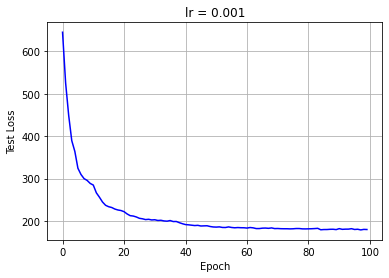

In [15]:
print(np.min(loss_test))
plt.figure(2)
plt.title(f'lr = {learn_rate}')
plt.plot(np.array(loss_test), 'b')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
#plt.yscale('log')
plt.grid()
plt.show()
#np.savez('VAE_Optical_linear_compression_6_512_hidden', data = np.array(loss_test))

In [16]:
dataiter = iter(test_dataset)
model.eval()
with torch.no_grad():
    digits, labels = dataiter.next()
    digits = digits.to(device)
    labels = labels.to(device)
    print(digits.shape)
    output, mean, std = model(digits)
    print(output.shape)
print(kl_loss(mean, std))

torch.Size([100, 196])
torch.Size([100, 196])
tensor(30.3084, device='cuda:3')


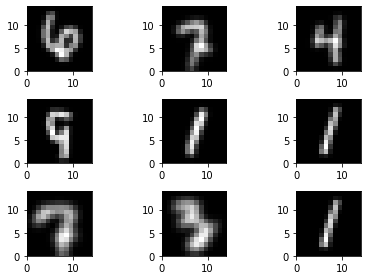

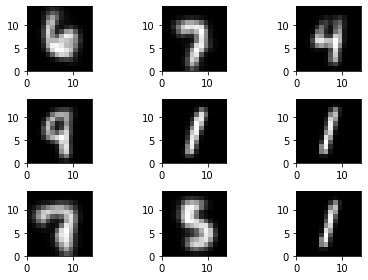

In [17]:
np.random.seed(95)
plots = 9
inds = np.random.randint(0, batch_size, size = plots)    
fig, axes = plt.subplots(int(np.sqrt(plots)), int(np.sqrt(plots)))
for i in range (int(np.sqrt(plots))):
    for j in range (int(np.sqrt(plots))):
        axes[i, j].imshow(digits[inds[i*int(np.sqrt(plots)) + j]].detach().cpu().view(pixels, pixels), interpolation = 'None', \
                       origin='upper', extent=[0, pixels, 0, pixels], cmap = 'gray')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(int(np.sqrt(plots)), int(np.sqrt(plots)))
for i in range (int(np.sqrt(plots))):
    for j in range (int(np.sqrt(plots))):
        axes[i, j].imshow(output[inds[i*int(np.sqrt(plots)) + j]].detach().cpu().view(pixels, pixels), interpolation = 'None', \
                       origin='upper', extent=[0, pixels, 0, pixels], cmap = 'gray')
plt.tight_layout()
plt.show()

In [18]:
dataiter = iter(fanout_train_dataset)
if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()
        
pixels = 14
with torch.no_grad():
    digits, labels = dataiter.next()
    digits = digits.to(device)
    print(digits.shape)
    output, mean, std = model(digits)
    print(output.shape)
    
criterion = nn.MSELoss(reduction = 'sum')
#criterion = piq.SSIMLoss(data_range = 1.)
print(criterion(output, digits) + kl_loss(mean, std))

torch.Size([100, 196])
torch.Size([100, 196])
tensor(1859.8549, device='cuda:3')


In [19]:
learn_rate = 1e-3
criterion = nn.MSELoss(reduction = 'sum')
#criterion = piq.SSIMLoss(data_range = 1.)
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
Epochs = 100
if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()
        
loss_train = []
loss_test = []
for epoch in range(Epochs):# loop over the dataset multiple times
    train_running_loss = 0.0
    model.train()
    # TRAINING ROUND
    for i, data in enumerate(fanout_train_dataset):
        # zero the parameter gradients
        optimizer.zero_grad()
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs, mean, std = model(inputs)
        loss = criterion(outputs, inputs) + kl_loss(mean, std)
        loss.backward()
        optimizer.step()
        #print(loss.detach().item())
        train_running_loss += loss.detach().item()         
    model.eval()
    loss_train.append(train_running_loss/(N_fanout_train_batch))#*batch_size))
    if (epoch%(Epochs/10) == 0) :
        print('Progress:  %d | Loss: %.6f'%(100*epoch/Epochs, train_running_loss/(N_fanout_train_batch)))#*batch_size)))
    with torch.no_grad():
        t_loss = 0.
        t_acc = 0.
        for p, tdata in enumerate(fanout_test_dataset):
            t_inputs, t_labels = tdata
            t_inputs = t_inputs.to(device)
            t_labels = t_labels.to(device)
            t_outputs, t_mean, t_std = model(t_inputs)
            t_loss += (criterion(t_outputs, t_inputs) + kl_loss(t_mean, t_std)).detach().item() 
        loss_test.append(t_loss/(N_fanout_test_batch))#*batch_size))
        #acc_test.append(t_acc/N_test_batch)
    if (epoch%(Epochs/10) == 0) :
#         print('Test Loss: %.6f | Test Accuracy: %.4f' 
#           %(t_loss/(N_test_batch*batch_size), t_acc/N_test_batch))
        print('Test Loss: %.6f' 
          %(t_loss/(N_fanout_test_batch)))#*batch_size)))

Progress:  0 | Loss: 484.234988
Test Loss: 338.357790
Progress:  10 | Loss: 187.050495
Test Loss: 224.076988
Progress:  20 | Loss: 170.172725
Test Loss: 204.909707
Progress:  30 | Loss: 160.369742
Test Loss: 197.886497
Progress:  40 | Loss: 153.873200
Test Loss: 192.865423
Progress:  50 | Loss: 149.008792
Test Loss: 186.784348
Progress:  60 | Loss: 144.801261
Test Loss: 184.049684
Progress:  70 | Loss: 141.467384
Test Loss: 181.170724
Progress:  80 | Loss: 139.178437
Test Loss: 180.586785
Progress:  90 | Loss: 137.290697
Test Loss: 180.952994


175.08415165653935


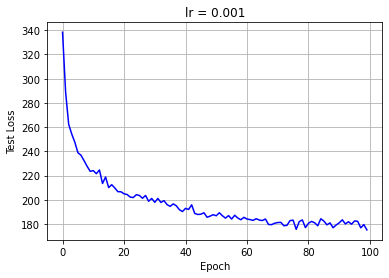

In [20]:
print(np.min(loss_test))
plt.figure(2)
plt.title(f'lr = {learn_rate}')
plt.plot(np.array(loss_test), 'b')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
#plt.yscale('log')
plt.grid()
plt.show()
#np.savez('VAE_Optical_linear_compression_6_512_hidden', data = np.array(loss_test))

In [21]:
dataiter = iter(fanout_test_dataset)
model.eval()
with torch.no_grad():
    digits, labels = dataiter.next()
    digits = digits.to(device)
    labels = labels.to(device)
    print(digits.shape)
    output, mean, std = model(digits)
    print(output.shape)
print(kl_loss(mean, std))

torch.Size([100, 196])
torch.Size([100, 196])
tensor(30.2853, device='cuda:3')


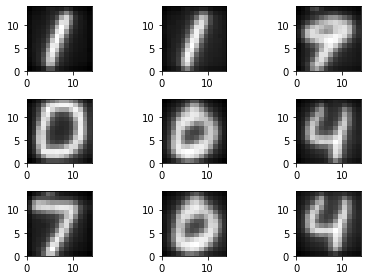

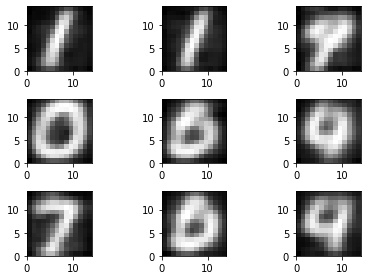

In [22]:
np.random.seed(91)
plots = 9
inds = np.random.randint(0, batch_size, size = plots)    
fig, axes = plt.subplots(int(np.sqrt(plots)), int(np.sqrt(plots)))
for i in range (int(np.sqrt(plots))):
    for j in range (int(np.sqrt(plots))):
        axes[i, j].imshow(digits[inds[i*int(np.sqrt(plots)) + j]].detach().cpu().view(pixels, pixels), interpolation = 'None', \
                       origin='upper', extent=[0, pixels, 0, pixels], cmap = 'gray')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(int(np.sqrt(plots)), int(np.sqrt(plots)))
for i in range (int(np.sqrt(plots))):
    for j in range (int(np.sqrt(plots))):
        axes[i, j].imshow(output[inds[i*int(np.sqrt(plots)) + j]].detach().cpu().view(pixels, pixels), interpolation = 'None', \
                       origin='upper', extent=[0, pixels, 0, pixels], cmap = 'gray')
plt.tight_layout()
plt.show()

tensor([[0., 0., 1.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:3')
torch.Size([196, 9])


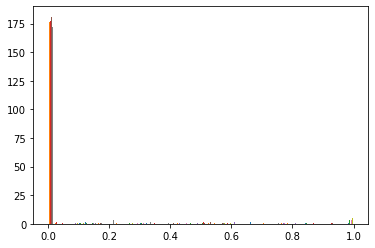

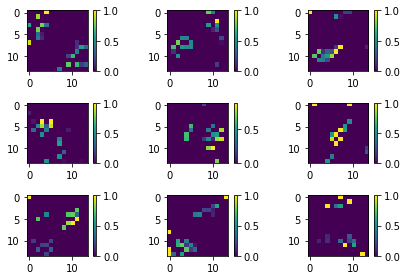

In [23]:
model.eval()
LCD_weights = []
with torch.no_grad():
    print(torch.clamp(model.W_Opt1, min = 0., max = 1.))
    print(model.W_Opt1.shape)
    plt.figure()
    plt.hist(torch.clamp(model.W_Opt1, min = 0., max = 1.).detach().cpu().numpy(), bins = 50)
    plt.show()
    fig, axes = plt.subplots(3, 3)
    for i in range (9):
        LCD_weights.append(np.copy(torch.clamp(model.W_Opt1, min = 0., max = 1.)[:,i].detach().cpu().numpy()))
        im = axes[i//3, i%3].imshow(torch.clamp(model.W_Opt1, min = 0., max = 1.)[:,i].detach().cpu().numpy().reshape(pixels, pixels))
        plt.colorbar(im,ax=axes[i//3,i%3])
    plt.tight_layout()
    plt.show()

In [25]:
import PIL
from scipy.interpolate import interp1d

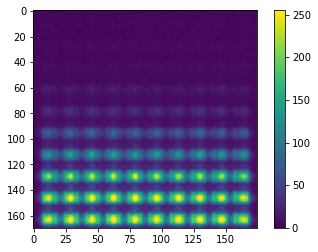

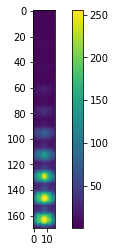

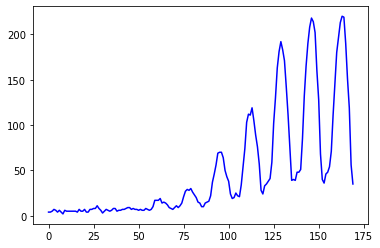

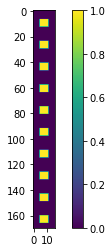

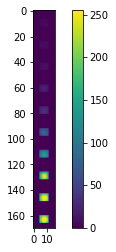

[[  5.69047619   7.69047619   9.07142857  17.35714286  28.92857143
   65.54761905 111.04761905 188.57142857 215.28571429 217.26190476]]


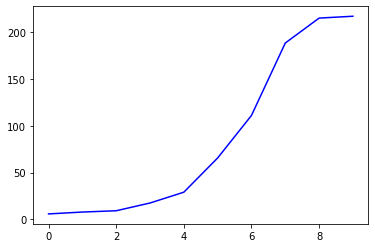

In [33]:
#Weight look-up table
file = '10_val_lookup.bmp'
image = np.array(PIL.Image.open(file)).astype(float)[123:293,525:700,0]
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.show()
value_image = np.copy(image[:, 71:88])
plt.figure()
plt.imshow(value_image)
plt.colorbar()
plt.show()
plt.figure()
plt.plot(value_image[:,6], 'b')
plt.show()

window_mat = np.zeros((17,17))
window = np.ones((6,7))
window_mat[7:13, 5:12] = window
window_mat = np.tile(window_mat, (10, 1))
plt.figure()
plt.imshow(window_mat)
plt.colorbar()
plt.show()
look_up_table = value_image*window_mat
plt.figure()
plt.imshow(look_up_table)
plt.colorbar()
plt.show()

n = 17
b = 10
look_up_table = look_up_table.T.reshape(-1, n, b, n).sum((-1, -3))/(6*7)
print(look_up_table)
plt.figure()
plt.plot(look_up_table[0], 'b')
plt.show()

[[  0   0   0   0   0   0   0   0   0   0]
 [ 25  25  25  25  25  25  25  25  25  25]
 [ 51  51  51  51  51  51  51  51  51  51]
 [ 76  76  76  76  76  76  76  76  76  76]
 [102 102 102 102 102 102 102 102 102 102]
 [127 127 127 127 127 127 127 127 127 127]
 [153 153 153 153 153 153 153 153 153 153]
 [178 178 178 178 178 178 178 178 178 178]
 [204 204 204 204 204 204 204 204 204 204]
 [229 229 229 229 229 229 229 229 229 229]]


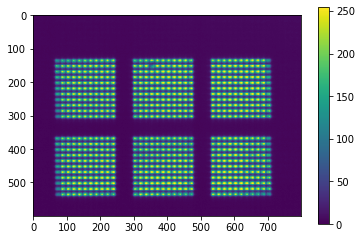

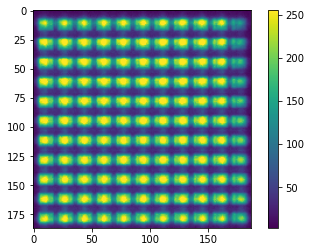

(187, 187)


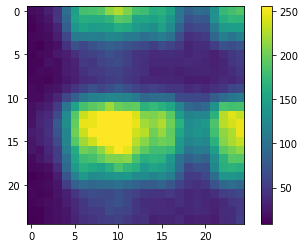

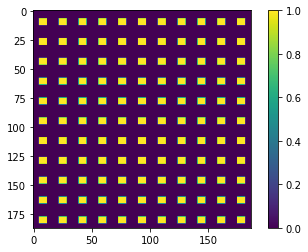

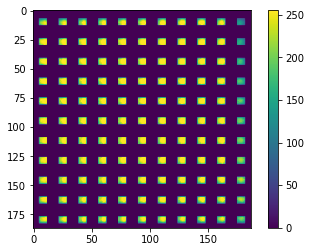

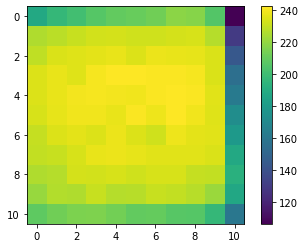

[0.02697821 0.03303672 0.03855495 0.07166732 0.12067938 0.27131172
 0.47196924 0.79494128 0.92614975 0.95389923]


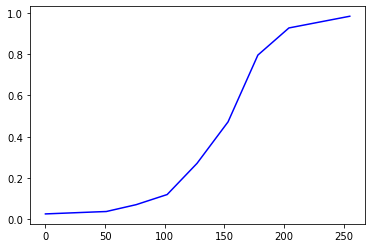

0.9827586828962875


In [35]:
vals = (255.*np.kron(np.arange(0., 1., 1/10.).reshape(10, 1), np.ones(10))).astype(np.uint8)
print(vals)
file = 'All_transparent.bmp'
image = np.array(PIL.Image.open(file)).astype(float)[:,:,0]
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.show()
vec1_image = np.copy(image[124:311,527:714])
plt.figure()
plt.imshow(vec1_image)
plt.colorbar()
plt.show()
print(vec1_image.shape)
plt.figure()
plt.imshow(vec1_image[30:55, 0:25])
plt.colorbar()
plt.show()

window_mat = np.zeros((17,17))
window = np.ones((6,7))
window_mat[7:13, 5:12] = window
window_mat = np.tile(window_mat, (11, 11))
plt.figure()
plt.imshow(window_mat)
plt.colorbar()
plt.show()

vec1_image = window_mat*vec1_image
plt.figure()
plt.imshow(vec1_image)
plt.colorbar()
plt.show()

n1 = 17
n2 = 17
b = vec1_image.shape[0]//17
vec1 = vec1_image.reshape(-1, n1, b, n2).sum((-1, -3))/(6*7)
plt.figure()
plt.imshow(vec1)
plt.colorbar()
plt.show()
frac_vals = vec1[0:10, 5]
modulation_table = look_up_table[0]/frac_vals
print(modulation_table)
look_up_function = interp1d(vals[:,0], modulation_table, kind = 'slinear', fill_value = 'extrapolate')
LCD_mod_vals = np.arange(0, 256, 1)
Modulation = look_up_function(LCD_mod_vals)
plt.figure()
plt.plot(LCD_mod_vals, Modulation, 'b')
plt.show()
print(Modulation[-1])

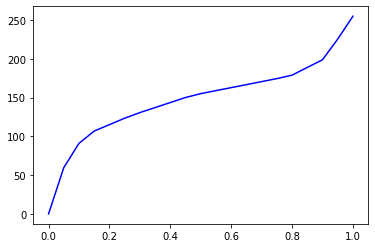

In [41]:
inv_look_up_function = interp1d(Modulation, LCD_mod_vals, kind = 'slinear', fill_value = (0., 255.), bounds_error=False)
x = np.arange(0, 1.05, 0.05)
y = inv_look_up_function(x)
plt.figure()
plt.plot(x, y, 'b')
plt.show()

In [42]:
LCD_weights = np.array(LCD_weights)

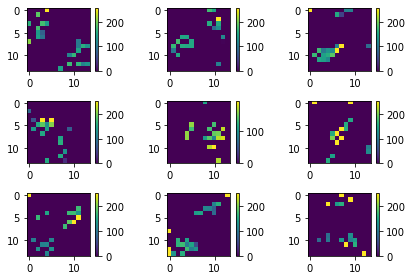

In [43]:
LCD_weights_to_write = inv_look_up_function(np.copy(LCD_weights))

fig, axes = plt.subplots(3, 3)
for i in range (9):
    im = axes[i//3, i%3].imshow(LCD_weights_to_write[i].reshape(pixels, pixels))
    plt.colorbar(im,ax=axes[i//3,i%3])
plt.tight_layout()
plt.show()

In [44]:
np.savez('Pretrained_LCD_weights_14x14_to_9_linear_optical_compression', weights = LCD_weights_to_write)